In [2]:
import matplotlib.pyplot as plt
from gym_anytrading.envs import StocksEnv
from finta import TA

In [3]:
#create a function to calculate the RSI
def calculate_rsi_ta(data):
    """
    This function calculates the RSI of the data
    :param data: pandas dataframe with the data
    :return data: pandas dataframe with the RSI
    """
    data['rsi'] = TA.RSI(data,14)
    return data



RSI

In [4]:
def calculate_rsi(prices, n=14):
    deltas = np.diff(prices)
    seed = deltas[:n + 1]
    up = seed[seed >= 0].sum() / n
    down = -seed[seed < 0].sum() / n
    rs = up / down
    rsi = [np.nan] * (n - 1) + [100. - 100. / (1. + rs)]

    for i in range(n, len(prices)):
        delta = deltas[i - 1]  # Cambio actual
        if delta > 0:
            upval = delta
            downval = 0.
        else:
            upval = 0.
            downval = -delta
        up = (up * (n - 1) + upval) / n
        down = (down * (n - 1) + downval) / n
        rs = up / down
        rsi.append(100. - 100. / (1. + rs))

    return rsi

In [28]:
import yfinance as yf
import numpy as np


data = yf.download('GOOG', start='2010-01-01', end= '2024-01-01',interval="1d")
prices = np.array(data['Adj Close'].values) #Adj Close prices
dates = np.array(data.index.values).astype('datetime64[ns]') #Dates
data['rsi'] = TA.RSI(data,14,column='adj close') #Relative Strength Index (RSI)
data['macd'] = TA.MACD(data,column='adj close')['MACD'] #MACD Line
data['macd_signal'] = TA.MACD(data, column='adj close')['SIGNAL'] #MACD Signal Line
data['bb_bbm'] = TA.BBANDS(data, column='adj close')['BB_MIDDLE'] #Bollinger Bands (BB) middle band (BBM)
data['bb_bbu'] = TA.BBANDS(data, column='adj close')['BB_UPPER'] #Bollinger Bands (BB) upper band (BBU)
data['bb_bbl'] = TA.BBANDS(data,column='adj close')['BB_LOWER'] #Bollinger Bands (BB) lower band (BBL)
data['bb_width'] = TA.BBWIDTH(data,column='adj close') #Bollinger Bands (BB) width
data['obv'] = TA.OBV(data,'adj close') #On Balance Volume (OBV)

data.fillna(0, inplace=True)
data = data[data.index > '2013-01-01']
data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,rsi,macd,macd_signal,bb_bbm,bb_bbu,bb_bbl,bb_width,obv
Date,,,,,,,,,,,,,,
2013-01-02,17.918339,18.107130,17.846855,18.013729,18.013729,102033017,63.613447,0.175738,0.174752,17.551662,18.196378,16.906946,0.073465,4.470655e+08
2013-01-03,18.055573,18.229919,17.950716,18.024191,18.024191,93075567,63.806858,0.191381,0.178078,17.592310,18.249053,16.935567,0.074663,5.401410e+08
2013-01-04,18.165413,18.467529,18.124067,18.380356,18.380356,110954331,69.709819,0.229868,0.188436,17.654763,18.362494,16.947032,0.080175,6.510953e+08
2013-01-07,18.317591,18.415474,18.196297,18.300158,18.300158,66476239,67.057713,0.251004,0.200950,17.709085,18.440659,16.977510,0.082621,5.846191e+08
2013-01-08,18.319834,18.338762,18.043119,18.264042,18.264042,67295297,65.842868,0.261822,0.213124,17.770218,18.470534,17.069902,0.078819,5.173238e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,142.130005,143.250000,142.054993,142.720001,142.720001,18494700,64.953258,1.421675,0.575959,135.933500,142.641226,129.225774,0.098691,3.806940e+09
2023-12-26,142.979996,143.945007,142.500000,142.820007,142.820007,11170100,65.115855,1.718241,0.804416,136.172000,143.506508,128.837492,0.107724,3.818110e+09
2023-12-27,142.830002,143.320007,141.050995,141.440002,141.440002,17288400,60.916000,1.820926,1.007718,136.313000,143.947932,128.678069,0.112021,3.800822e+09


## Enviroment

In [109]:
def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Adj Close'].to_numpy()[start:end]
    signal_features = env.df.loc[:,['rsi','Volume','macd','macd_signal','bb_bbm','bb_bbu','bb_bbl','bb_width','obv']].to_numpy()[start:end]
    return prices, signal_features

# def reward_function(env,action):
#     pass


In [117]:
class customEnv(StocksEnv):
    """
    Custom Environment for RL trading
    """
    _process_data = add_signals
    position_type="long"

    # _calculate_reward = reward_function
env = customEnv(df=data, window_size=14, frame_bound=(14,100))
    

In [118]:
env.action_space

Discrete(2)

train

In [119]:
from stable_baselines3.common.vec_env import DummyVecEnv
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf


env_maker = lambda: env
env_train = DummyVecEnv([env_maker])

In [120]:
from stable_baselines3 import A2C

model = A2C('MlpPolicy', env_train, verbose=1)
model.learn(total_timesteps=5000)

Using cuda device
------------------------------------
| time/                 |          |
|    fps                | 199      |
|    iterations         | 100      |
|    time_elapsed       | 2        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.69    |
|    explained_variance | 0.115    |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 0.0751   |
|    value_loss         | 0.0495   |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 209      |
|    iterations         | 200      |
|    time_elapsed       | 4        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -0.663   |
|    explained_variance | 0.15     |
|    learning_rate      | 0.0007   |
|    n_updates          | 199      |
|    policy_loss        | -0.249   |
|    value_loss     

Evaluation

In [251]:

data = yf.download('NFLX', start='2010-01-01', end= '2024-01-01',interval="1d")
prices = np.array(data['Adj Close'].values) #Adj Close prices
dates = np.array(data.index.values).astype('datetime64[ns]') #Dates
data['rsi'] = TA.RSI(data,14,column='adj close') #Relative Strength Index (RSI)
data['macd'] = TA.MACD(data,column='adj close')['MACD'] #MACD Line
data['macd_signal'] = TA.MACD(data, column='adj close')['SIGNAL'] #MACD Signal Line
data['bb_bbm'] = TA.BBANDS(data, column='adj close')['BB_MIDDLE'] #Bollinger Bands (BB) middle band (BBM)
data['bb_bbu'] = TA.BBANDS(data, column='adj close')['BB_UPPER'] #Bollinger Bands (BB) upper band (BBU)
data['bb_bbl'] = TA.BBANDS(data,column='adj close')['BB_LOWER'] #Bollinger Bands (BB) lower band (BBL)
data['bb_width'] = TA.BBWIDTH(data,column='adj close') #Bollinger Bands (BB) width
data['obv'] = TA.OBV(data,'adj close') #On Balance Volume (OBV)

data.fillna(0, inplace=True)
data = data[data.index > '2013-01-01']
data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,rsi,macd,macd_signal,bb_bbm,bb_bbu,bb_bbl,bb_width,obv
Date,,,,,,,,,,,,,,
2013-01-02,13.601429,13.687143,12.955714,13.144286,13.144286,19431300,59.786015,0.409583,0.493112,12.886500,13.904607,11.868393,0.158011,-1.938482e+08
2013-01-03,13.138571,13.988571,13.075714,13.798571,13.798571,27912500,66.916605,0.443505,0.483191,12.957500,14.023396,11.891604,0.164522,-1.659357e+08
2013-01-04,13.791429,13.958571,13.648571,13.711429,13.711429,17761100,65.256939,0.458076,0.478168,13.047571,14.042879,12.052264,0.152566,-1.836968e+08
2013-01-07,13.770000,14.535714,13.731429,14.171429,14.171429,45550400,69.550191,0.500967,0.482728,13.140643,14.192091,12.089195,0.160030,-1.381464e+08
2013-01-08,14.287143,14.427143,13.828571,13.880000,13.880000,24714900,64.142371,0.505614,0.487305,13.220500,14.239750,12.201250,0.154192,-1.628613e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,494.000000,496.019989,485.450012,486.760010,486.760010,2701100,62.629263,11.455084,10.464237,471.507500,500.795062,442.219937,0.124229,1.029577e+09
2023-12-26,489.390015,491.480011,486.380005,491.190002,491.190002,2034500,64.613544,11.575034,10.686397,472.108499,502.529506,441.687492,0.128873,1.031611e+09
2023-12-27,491.239990,494.019989,489.250000,491.790009,491.790009,2561300,64.885498,11.584966,10.866111,472.748000,504.295854,441.200145,0.133466,1.034172e+09


In [258]:
from gym_anytrading.envs import Actions

env_test = customEnv(df=data, window_size=14, frame_bound=(15, 300))
obs,_ = env_test.reset(seed=42)
r= []
action_stats = {Actions.Sell: 0, Actions.Buy: 0}
buy_rsi = []
sell_rsi = []
lt=0
while True:
    actual_lt= env_test._last_trade_tick
    obs = obs[np.newaxis, ...] 
    action, _states = model.predict(obs)
    # print(env_test._last_trade_tick)
    # break
    # print('skipped',action)
    if lt!=actual_lt:
        # print(action,"Last trade tick:",actual_lt)
        lt=actual_lt
        
        # print(action)
    action_stats[Actions(action)] += 1
    if action == 0:
        # print("Sell")
        # sell_rsi.append()
        sell_rsi.append(env_test.signal_features[env_test._last_trade_tick][0])

        pass
    elif action == 1:
        # print("Buy")
        buy_rsi.append(env_test.signal_features[env_test._last_trade_tick][0])
    # else:
        # print('??')
    # print(rewards)
    obs, rewards,_ , done, info= env_test.step(action)

    r.append(rewards)
    if done:
        print("info",info)
        break

info {'total_reward': 37.26427459716797, 'total_profit': 0.9103132452786629, 'position': <Positions.Long: 1>}


In [263]:
env_test.signal_features[env_test._current_tick] #obtener los valores del dia que se va a predecir

array([5.43242917e+01, 1.21345000e+07, 1.50980314e+00, 2.06492676e+00,
       6.31920715e+01, 6.56383015e+01, 6.07458416e+01, 7.74220538e-02,
       5.14332000e+08])

In [254]:
sum(r)

16.712852478027344

In [255]:
print("env information:")
print("> shape:", env_test.unwrapped.shape)
print("> df.shape:", env_test.unwrapped.df.shape)
print("> prices.shape:", env_test.unwrapped.prices.shape)
print("> signal_features.shape:", env_test.unwrapped.signal_features.shape)
print("> max_possible_profit:", env_test.unwrapped.max_possible_profit())


env information:
> shape: (14, 9)
> df.shape: (2768, 14)
> prices.shape: (299,)
> signal_features.shape: (299, 9)
> max_possible_profit: 41.69065663868925


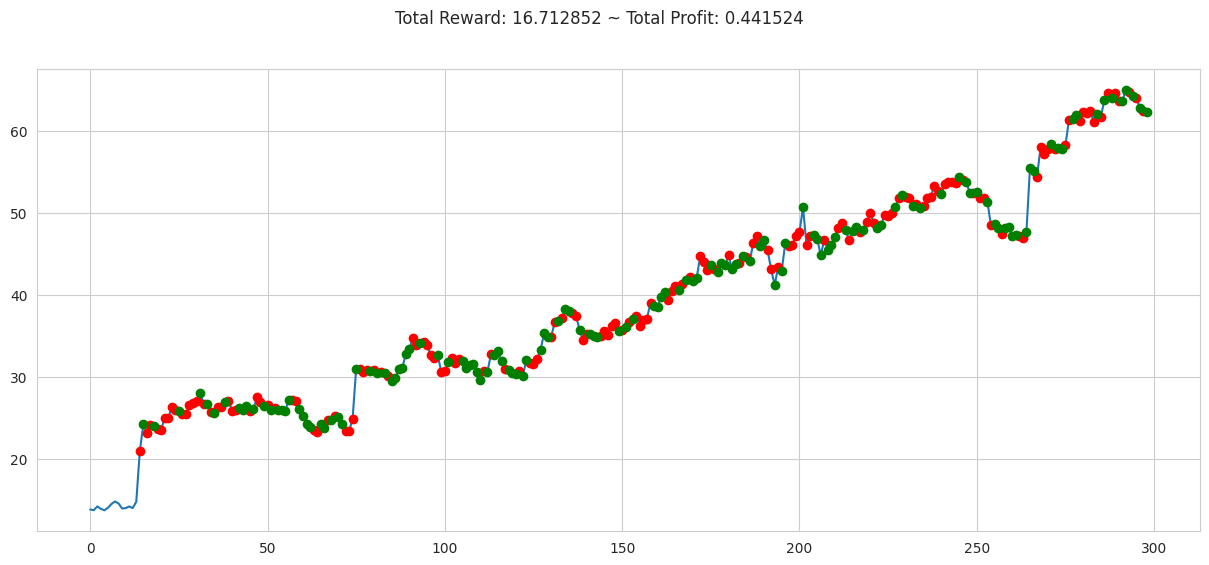

In [256]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,6))
plt.cla()
env_test.render_all()
plt.show()

## ELSE

In [85]:
env_test.step([2])

(array([[42.90572383],
        [41.18560508],
        [45.41570043],
        [44.84428623],
        [41.58389845],
        [50.6287522 ],
        [50.53785334],
        [49.6733183 ],
        [55.72457154],
        [58.62552725],
        [56.61125879],
        [55.63836965],
        [54.90352122],
        [52.71871221]]),
 0,
 False,
 False,
 {'total_reward': 0.0, 'total_profit': 1.0, 'position': <Positions.Short: 0>})

In [3]:

rsi = calculate_rsi(prices)



[*********************100%%**********************]  1 of 1 completed


## Enviroment

# Vengo al tiro igual